In [2]:
# Install kaggle CLI
!pip install kaggle

# Set Kaggle username and API key directly (replace with your credentials)
kaggle_username = ""  #replace with your kaggle username
kaggle_api_key = ""   #replace with your kaggle API key

# Set Kaggle API credentials directly
import json
import os

kaggle_json_path = '/content/kaggle.json'
credentials = {"username": kaggle_username, "key": kaggle_api_key}

with open(kaggle_json_path, 'w') as kaggle_json:
    json.dump(credentials, kaggle_json)

# Kaggle config
!mkdir -p ~/.kaggle
!mv {kaggle_json_path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using the Kaggle dataset link
!kaggle datasets download -d niteshfre/chessman-image-dataset

# Unzip the dataset
!unzip -q /content/chessman-image-dataset.zip -d /content/chessman-image-dataset

 71% 41.0M/57.6M [00:00<00:00, 69.9MB/s]
100% 57.6M/57.6M [00:00<00:00, 77.0MB/s]


# **Set dataset Path**

In [3]:
dataset_path = "./chessman-image-dataset/Chessman-image-dataset/Chess"

# **Get List class Names**

In [4]:
class_names = os.listdir(dataset_path)
print(f"Number of Classes: {len(class_names)}")
print(f"Dataset Classes: {class_names}")


Number of Classes: 6
Dataset Classes: ['Queen', 'Pawn', 'Knight', 'King', 'Rook', 'Bishop']


# **Class Distribution**

In [5]:
class_distribution = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in class_names}
print("Class Distribution:",class_distribution)


Class Distribution: {'Queen': 78, 'Pawn': 107, 'Knight': 106, 'King': 76, 'Rook': 102, 'Bishop': 87}


# **Display image for each class**

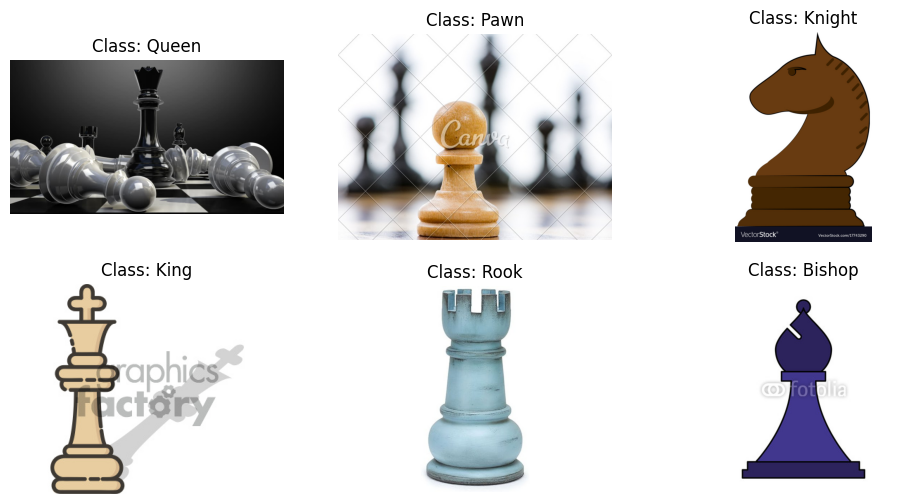

In [6]:
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

plt.figure(figsize=(12, 6))

for i, class_name in enumerate(class_names, 1):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)

    # Display one random image from each class
    random_image = random.choice(image_files)
    image_path = os.path.join(class_path, random_image)

    plt.subplot(2, len(class_names) // 2, i)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

# **Balancing the data**

In [7]:
# Specify the desired number of samples after downsampling
desired_samples = min([len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in class_names])
print("Desired number:",desired_samples)

Desired number: 76


In [8]:
# Create a directory to save downsampled images
new_dataset_path = "./chessman-image-dataset/Chessman-image-dataset"
downsampled_path = os.path.join(new_dataset_path, "downsampled")
os.makedirs(downsampled_path, exist_ok=True)

In [9]:
import shutil

for class_name in class_names:
    class_path_original = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path_original)

    # Create a directory for the current class within the downsampled path
    class_path_downsampled = os.path.join(downsampled_path, class_name)
    os.makedirs(class_path_downsampled, exist_ok=True)

    # Randomly select images to keep for downsampling
    selected_images = random.sample(image_files, desired_samples)

    # Save downsampled images to the new directory
    for image_file in selected_images:
        source_path = os.path.join(class_path_original, image_file)
        destination_path = os.path.join(class_path_downsampled, image_file)
        shutil.copyfile(source_path, destination_path)

In [10]:
# Display the number of images for each class after downsampling
print("Number of images after downsampling:")
for class_name in class_names:
    class_path = os.path.join(downsampled_path, class_name)
    num_images_after_downsampling = len(os.listdir(class_path))
    print(f"{class_name}: {num_images_after_downsampling} images")


Number of images after downsampling:
Queen: 76 images
Pawn: 76 images
Knight: 76 images
King: 76 images
Rook: 76 images
Bishop: 76 images


# Data augmentation & generate train and test **data**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)


# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    downsampled_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical', #because we have 6 classes
    subset='training'
)

# No Data Augmentation for Testing
validation_generator = train_datagen.flow_from_directory(
    downsampled_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  #because we have 6 classes
    subset='validation'
)

Found 361 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


# **Models**

# **MobileNetV2**

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Create the base MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create the model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data = validation_generator ,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
eval_result = model.evaluate(validation_generator)
print("Test Accuracy:", eval_result[1])

# Save the trained model
model.save('chess_mobileNet_model.keras')



9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/100
23/23 [==============================] - 34s 1s/step - loss: 1.8020 - accuracy: 0.2521 - val_loss: 1.3530 - val_accuracy: 0.5444
Epoch 2/100
23/23 [==============================] - 28s 1s/step - loss: 1.1900 - accuracy: 0.5900 - val_loss: 1.0461 - val_accuracy: 0.6222
Epoch 3/100
23/23 [==============================] - 25s 1s/step - loss: 0.9419 - accuracy: 0.6925 - val_loss: 0.9629 - val_accuracy: 0.6444
Epoch 4/100
23/23 [==============================] - 25s 1s/step - loss: 0.7861 - accuracy: 0.7535 - val_loss: 0.7953 - val_accuracy: 0.7889
Epoch 5/100
23/23 [==============================] - 25s 1s/step - loss: 0.6711 - accuracy: 0.8006 - val_loss: 0.7426 - val_accuracy: 0.7556
Epoch 6/100
23/23 [==============================] - 29s 1s/step - loss: 0.6167 - accuracy: 0.8393 - val_loss: 0.7172 - val_accuracy: 0.7222
Epoch 7/100
23/23 [==============================] - 25s 1s/step - loss: 0.5610 - accuracy:

# **InceptionV3**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionV3

# Create the base InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create the model
model_InceptionV3 = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model_InceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model_InceptionV3.fit(
    train_generator,
    epochs=100,
    validation_data = validation_generator ,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
eval_result = model_InceptionV3.evaluate(validation_generator)
print("Test Accuracy:", eval_result[1])

# Save the trained model
model_InceptionV3.save('chess_inception_model.keras')


87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/100
23/23 [==============================] - 80s 3s/step - loss: 1.7508 - accuracy: 0.2853 - val_loss: 1.3621 - val_accuracy: 0.4000
Epoch 2/100
23/23 [==============================] - 62s 3s/step - loss: 1.1318 - accuracy: 0.5928 - val_loss: 1.0331 - val_accuracy: 0.6444
Epoch 3/100
23/23 [==============================] - 68s 3s/step - loss: 0.8765 - accuracy: 0.6953 - val_loss: 0.8821 - val_accuracy: 0.7000
Epoch 4/100
23/23 [==============================] - 60s 3s/step - loss: 0.7350 - accuracy: 0.7396 - val_loss: 0.8633 - val_accuracy: 0.6556
Epoch 5/100
23/23 [==============================] - 68s 3s/step - loss: 0.6614 - accuracy: 0.7507 - val_loss: 0.7600 - val_accuracy: 0.7222
Epoch 6/100
23/23 [==============================] - 62s 3s/step - loss: 0.5923 - accuracy: 0.8116 - val_loss: 0.6942 - val_accuracy: 0.7333
Epoch 7/100
23/23 [==============================] - 60s 3s/step - loss: 0.5118 - accurac

# **DenseNet201**

In [13]:
from tensorflow.keras.applications import DenseNet201


# Create the base DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create the model
model_DenseNet201 = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model_DenseNet201.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model_DenseNet201.fit(
    train_generator,
    epochs=100,
    validation_data = validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
eval_result = model_DenseNet201.evaluate(validation_generator)
print("Test Accuracy:", eval_result[1])

# Save the trained model
model_DenseNet201.save('chess_DenseNet_model.keras')

74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/100
23/23 [==============================] - 153s 5s/step - loss: 1.7626 - accuracy: 0.2798 - val_loss: 1.3743 - val_accuracy: 0.5667
Epoch 2/100
23/23 [==============================] - 135s 6s/step - loss: 1.1896 - accuracy: 0.6066 - val_loss: 1.1330 - val_accuracy: 0.5667
Epoch 3/100
23/23 [==============================] - 116s 5s/step - loss: 0.9560 - accuracy: 0.7119 - val_loss: 0.9672 - val_accuracy: 0.6444
Epoch 4/100
23/23 [==============================] - 136s 6s/step - loss: 0.7990 - accuracy: 0.7507 - val_loss: 0.8294 - val_accuracy: 0.7667
Epoch 5/100
23/23 [==============================] - 137s 6s/step - loss: 0.7205 - accuracy: 0.7922 - val_loss: 0.8017 - val_accuracy: 0.7444
Epoch 6/100
23/23 [==============================] - 135s 6s/step - loss: 0.6099 - accuracy: 0.8560 - val_loss: 0.6788 - val_accuracy: 0.7778
Epoch 7/100
23/23 [==============================] - 135s 6s/step - loss: 0.5492 - 

# **Test**

1/1 [==============================] - 6s 6s/step
Top Prediction: ('Rook', 0.9981887)


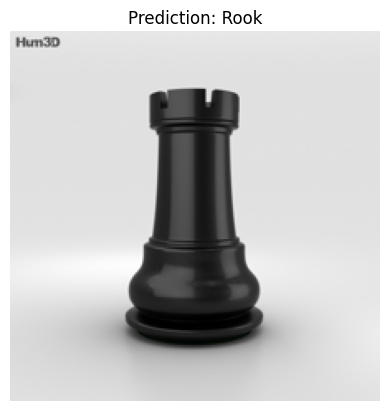

In [14]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

# Download the image from URL
url = "https://360view.hum3d.com/zoom/Tools/Classic_Chess_Rook_Black_1000_0001.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))


img = img.convert('RGB')

# Preprocess the image
img = img.resize((224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Assuming num_classes is the number of your classes
num_classes = len(train_generator.class_indices)

# Load the saved model
loaded_model = load_model('/content/chess_DenseNet_model.keras')

# Make predictions
predictions = loaded_model.predict(img_array)

# Decode predictions
class_indices = np.argmax(predictions, axis=1)
class_labels = [class_name for class_name, idx in train_generator.class_indices.items() if idx == class_indices[0]]

# Display the top prediction
top_prediction = (class_labels[0], predictions[0, class_indices[0]])

print(f"Top Prediction: {top_prediction}")

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.title(f"Prediction: {class_labels[0]}")
plt.show()

